# Preferential Bayesian Optimization: RANDOM
This notebook demonstrates the use of random querying on ordinal (preference) data.

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
objective = PBO.objectives.forrester
objective_low = 0.
objective_high = 1.
objective_name = "Forrester"
acquisition_name = "RANDOM"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name

In [3]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 3
num_inducing_init = 3
num_discrete_per_dim = 10000 # Discretization of continuous input space

In [4]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/sebtsh/PBO/notebooks/RANDOM/results/PBO_RANDOM_Forrester/  created 


Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

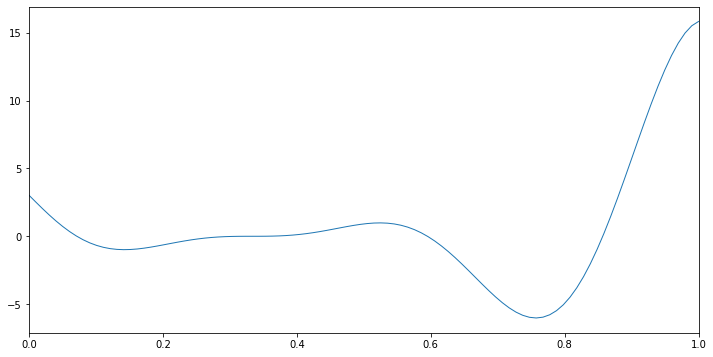

In [5]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, objective(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [6]:
def plot_gp(model, X, y, title, cmap="Spectral"):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

    plt.savefig(fname=results_dir + title + ".png")

In [7]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [8]:
def train_and_visualize(X, y, num_inducing, title):
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k, indifference_threshold = PBO.models.learning_stochastic.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         lengthscale=0.05,
                                                                         num_steps=3000)
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, u_mean, title)
    
    return model, inputs, u_mean, inducing_vars

In [9]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [10]:
def best_guess(model):
    """
    :return: tensor of shape (input_dims) a GP model's best guess of the global maximum of f.
    """
    xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [11]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

In [14]:
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])  # REMOVE LATER

In [15]:
X_results[0] = X
y_results[0] = y

Create the initial values for each run:

In [12]:
np.random.seed(0)
init_points = np.random.uniform(low=objective_low, high=objective_high, size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

In [ ]:
for run in range(1, num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run_{}:_Initial_model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 
        
        existing_idx = np.random.randint(0, inputs.shape[0])
        existing_input = inputs[existing_idx]
        random_input = np.random.uniform(low=objective_low, 
                                         high=objective_high, 
                                         size=(1, input_dims))
        
        next_query = np.zeros((num_choices, input_dims))
        next_query[0, :] = existing_input
        next_query[1, :] = random_input
        print("Evaluation %s: Next query is %s" % (evaluation, next_query))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = np.concatenate([y, get_noisy_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   num_inducing_init + evaluation + 1, 
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

Beginning run 1
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.6190260095654883 in 0.3899s
Negative ELBO at step 500: 2.2648449344707373 in 53.7838s
Negative ELBO at step 1000: 1.9196635811703056 in 52.1307s
Negative ELBO at step 1500: 1.9117469794477837 in 53.3287s
Negative ELBO at step 2000: 1.8537290167787912 in 52.0696s
Negative ELBO at step 2500: 1.716441402132271 in 50.8914s
Beginning evaluation 0
Evaluation 0: Next query is [[0.4236548]
 [0.3743232]]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 6.598172704105455 in 0.2042s
Negative ELBO at step 500: 2.8131201587915236 in 64.2867s
Negative ELBO at step 1000: 2.680215266491444 in 62.3473s
Negative ELBO at step 1500: 2.6027834347110628 in 64.7897s
Negative ELBO at step 2000: 2.5577691462686047 in 63.4791s
Negative ELBO at step 2500: 2.539756631024968 in 63.0727s
Beginning evaluation 1
Evaluation 1: Next query is [[0.54488318]
 [0.06530421]]
Evaluation 1: Training model


Negative ELBO at step 2000: 14.019201489467191 in 228.9408s
Negative ELBO at step 2500: 13.533786299125985 in 233.1464s
Beginning evaluation 16
Evaluation 16: Next query is [[0.10590615]
 [0.68493444]]
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 195812.88120635893 in 0.6285s
Negative ELBO at step 500: 628.1479884543129 in 242.7770s
Negative ELBO at step 1000: 336.3180645485011 in 243.2927s
Negative ELBO at step 1500: 178.79109744442547 in 243.5132s
Negative ELBO at step 2000: 125.70698032065863 in 239.6974s
Negative ELBO at step 2500: 81.54258809099636 in 240.4510s
Beginning evaluation 17
Evaluation 17: Next query is [[0.4236548 ]
 [0.39916115]]
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 645894.550874361 in 0.7403s
Negative ELBO at step 500: 4107.83892014516 in 251.8830s
Negative ELBO at step 1000: 3409.4631404510865 in 253.1421s
Negative ELBO at step 1500: 1973.1444581667618 in 254.3527s
N

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 2
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.9982499301555046 in 0.1426s
Negative ELBO at step 500: 2.2423508124230938 in 53.4520s
Negative ELBO at step 1000: 2.026195301699059 in 52.8417s
Negative ELBO at step 1500: 1.8953096443823683 in 50.9811s
Negative ELBO at step 2000: 1.9199292341569885 in 54.0955s
Negative ELBO at step 2500: 1.8596718719027883 in 51.5747s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Evaluation 0: Next query is [[0.96366276]
 [0.80269214]]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 453.31129538445725 in 0.1719s
Negative ELBO at step 500: 15.272816225183856 in 64.5195s
Negative ELBO at step 1000: 16.95361349202311 in 64.2663s
Negative ELBO at step 1500: 16.38738135591823 in 62.9627s
Negative ELBO at step 2000: 12.015437225135196 in 64.1040s
Negative ELBO at step 2500: 9.249481438030898 in 62.0305s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Evaluation 1: Next query is [[0.80269214]
 [0.37191875]]
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 13.837773296162563 in 0.2252s
Negative ELBO at step 500: 3.805920697397299 in 74.4512s
Negative ELBO at step 1000: 3.588581627591011 in 75.7622s
Negative ELBO at step 1500: 3.658506931568498 in 76.0321s
Negative ELBO at step 2000: 3.9731987661633443 in 73.7017s
Negative ELBO at step 2500: 3.669975185207815 in 75.9661s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Evaluation 2: Next query is [[0.37191875]
 [0.57184364]]
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 67.24799486891594 in 0.2834s
Negative ELBO at step 500: 4.542950526758437 in 87.0786s
Negative ELBO at step 1000: 4.21316008401839 in 86.7000s
Negative ELBO at step 1500: 3.998079783867615 in 86.6413s
Negative ELBO at step 2000: 3.971321615598429 in 86.3638s
Negative ELBO at step 2500: 3.9621675941778642 in 84.1306s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Evaluation 3: Next query is [[0.43758721]
 [0.77303498]]
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 19.442036527786893 in 0.2600s
Negative ELBO at step 500: 4.586729057535881 in 98.4485s
Negative ELBO at step 1000: 4.342786825670371 in 97.8960s
Negative ELBO at step 1500: 4.394557404236258 in 96.5627s
Negative ELBO at step 2000: 4.387130455770963 in 95.8773s
Negative ELBO at step 2500: 4.4113892419048755 in 98.2523s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Evaluation 4: Next query is [[0.77303498]
 [0.84285489]]
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 811.0345110950244 in 0.3487s
Negative ELBO at step 500: 9.668388232410686 in 110.8817s
Negative ELBO at step 1000: 8.63879823863213 in 108.0490s
Negative ELBO at step 1500: 7.481191575346219 in 105.9885s
Negative ELBO at step 2000: 6.836358398216758 in 109.1772s
Negative ELBO at step 2500: 6.567553133571354 in 109.3778s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Evaluation 5: Next query is [[0.77303498]
 [0.93530189]]
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1133.2937244913267 in 0.3278s
Negative ELBO at step 500: 12.093780396199298 in 119.5222s
Negative ELBO at step 1000: 7.891676937008208 in 118.8285s
Negative ELBO at step 1500: 6.682898243682774 in 118.2272s
Negative ELBO at step 2000: 6.167739153100882 in 121.1202s
Negative ELBO at step 2500: 5.875896041131227 in 119.5875s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Evaluation 6: Next query is [[0.80269214]
 [0.59606499]]
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 319.73124339112263 in 0.3599s
Negative ELBO at step 500: 11.595564115106876 in 127.5681s
Negative ELBO at step 1000: 9.50326432938067 in 129.6328s
Negative ELBO at step 1500: 7.342995527125616 in 130.8658s
Negative ELBO at step 2000: 7.218316485046513 in 134.5543s
Negative ELBO at step 2500: 6.891184314315561 in 130.9026s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Evaluation 7: Next query is [[0.37191875]
 [0.403026  ]]
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 71.43531516892222 in 0.3735s
Negative ELBO at step 500: 7.628581390407973 in 142.0174s
Negative ELBO at step 1000: 6.702984068538038 in 142.7267s
Negative ELBO at step 1500: 6.376074013437295 in 143.8593s
Negative ELBO at step 2000: 6.327295948977445 in 142.7544s
Negative ELBO at step 2500: 6.191663532332502 in 146.1270s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Evaluation 8: Next query is [[0.93530189]
 [0.66331792]]
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1630.1291363567273 in 0.4683s
Negative ELBO at step 500: 14.20206662106063 in 152.2482s
Negative ELBO at step 1000: 9.454311060669419 in 152.2885s
Negative ELBO at step 1500: 8.044850231401446 in 153.6398s
Negative ELBO at step 2000: 7.857505547212952 in 152.2730s
Negative ELBO at step 2500: 7.264587422058502 in 152.5281s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Evaluation 9: Next query is [[0.80269214]
 [0.73328913]]
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 103.36235970748214 in 0.4563s
Negative ELBO at step 500: 9.570027545373103 in 164.5288s
Negative ELBO at step 1000: 7.941263964699612 in 164.4497s
Negative ELBO at step 1500: 7.549051651471167 in 168.7367s
Negative ELBO at step 2000: 7.591180458452557 in 167.6276s
Negative ELBO at step 2500: 7.541667312618657 in 163.5975s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Evaluation 10: Next query is [[0.37191875]
 [0.63087107]]
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1113.8802016562383 in 0.4737s
Negative ELBO at step 500: 22.240473250514746 in 174.8970s
Negative ELBO at step 1000: 14.667281517769087 in 176.2671s
Negative ELBO at step 1500: 12.660475100125598 in 176.1620s
Negative ELBO at step 2000: 9.712674557669066 in 172.4524s
Negative ELBO at step 2500: 9.477412437043094 in 175.1204s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Evaluation 11: Next query is [[0.84285489]
 [0.97817217]]
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 106.202797482807 in 0.5261s
Negative ELBO at step 500: 10.13126607716703 in 186.9011s
Negative ELBO at step 1000: 8.743451028366287 in 186.2984s
Negative ELBO at step 1500: 8.309233923094176 in 190.4324s
Negative ELBO at step 2000: 8.392708804933788 in 187.9103s
Negative ELBO at step 2500: 8.302091589979415 in 189.0785s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Evaluation 12: Next query is [[0.891773  ]
 [0.86678854]]
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 33725.52917935346 in 0.5496s
Negative ELBO at step 500: 131.65944423267976 in 195.2781s
Negative ELBO at step 1000: 103.89666437496753 in 199.7997s
Negative ELBO at step 1500: 55.20007389099993 in 196.1686s
Negative ELBO at step 2000: 33.50583810582847 in 197.8328s
Negative ELBO at step 2500: 25.17255065502664 in 200.0674s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Evaluation 13: Next query is [[0.66331792]
 [0.72944811]]
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 22328.98927858664 in 0.5659s
Negative ELBO at step 500: 137.29370282694583 in 209.1330s
Negative ELBO at step 1000: 44.687658735650274 in 212.2198s
Negative ELBO at step 1500: 34.92667639208719 in 208.2988s
Negative ELBO at step 2000: 30.276677504289268 in 210.3163s
Negative ELBO at step 2500: 24.236099587910218 in 208.8188s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Evaluation 14: Next query is [[0.891773  ]
 [0.47558912]]
Evaluation 14: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2035633.1629358043 in 0.6249s
Negative ELBO at step 500: 2599.6315217497654 in 220.8216s
Negative ELBO at step 1000: 1029.850672878508 in 221.9839s
Negative ELBO at step 1500: 1004.0612077309289 in 217.4265s
Negative ELBO at step 2000: 687.71378390944 in 219.6177s
Negative ELBO at step 2500: 399.97418252303265 in 220.5367s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Evaluation 15: Next query is [[0.80269214]
 [0.44077719]]
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 527589.5529119681 in 0.6319s
Negative ELBO at step 500: 5820.090215641521 in 231.9653s
Negative ELBO at step 1000: 2315.1129481355724 in 234.0939s
Negative ELBO at step 1500: 2051.3327410400425 in 230.4243s
Negative ELBO at step 2000: 1167.6351323922952 in 233.3403s
Negative ELBO at step 2500: 1013.8145088929464 in 233.1511s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Evaluation 16: Next query is [[0.80269214]
 [0.5349082 ]]
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 80957.08650870889 in 0.6832s
Negative ELBO at step 500: 850.0228660649824 in 242.5497s
Negative ELBO at step 1000: 305.5386164632156 in 245.3315s
Negative ELBO at step 1500: 243.299308429979 in 241.0066s
Negative ELBO at step 2000: 153.16010640409854 in 244.2988s
Negative ELBO at step 2500: 98.63509899768802 in 246.6542s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Evaluation 17: Next query is [[0.47558912]
 [0.58796713]]
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5076.4781683846095 in 0.6417s
Negative ELBO at step 500: 39.244137721142195 in 253.6388s
Negative ELBO at step 1000: 20.578930825139615 in 257.2203s
Negative ELBO at step 1500: 16.471180198083 in 253.7267s
Negative ELBO at step 2000: 14.808984450284022 in 254.3299s
Negative ELBO at step 2500: 14.029655725313745 in 257.4319s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Evaluation 18: Next query is [[0.93530189]
 [0.9485403 ]]
Evaluation 18: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 58097.83451538977 in 0.8062s
Negative ELBO at step 500: 179.73381212244675 in 265.1949s
Negative ELBO at step 1000: 110.88464326286558 in 269.4540s
Negative ELBO at step 1500: 88.53780894377228 in 264.0180s
Negative ELBO at step 2000: 49.14325967032806 in 267.3983s
Negative ELBO at step 2500: 31.924151722804986 in 266.6426s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 19
Evaluation 19: Next query is [[0.9485403 ]
 [0.33060053]]
Evaluation 19: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1065213.5872198215 in 0.8240s
Negative ELBO at step 500: 2904.647257151159 in 332.4221s
Negative ELBO at step 1000: 1858.1847312623654 in 324.9711s
Negative ELBO at step 1500: 1117.4420936808724 in 333.2868s
Negative ELBO at step 2000: 685.0413683275551 in 329.4274s
Negative ELBO at step 2500: 511.6584130949411 in 335.7680s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 3
Indifference_threshold is trainable.
Negative ELBO at step 0: 5.220508683539478 in 0.2634s
Negative ELBO at step 500: 2.185856966927305 in 65.5659s
Negative ELBO at step 1000: 2.136824124474003 in 63.4933s
Negative ELBO at step 1500: 2.0185511397424882 in 58.0700s
Negative ELBO at step 2000: 2.085313288514406 in 66.9617s
Negative ELBO at step 2500: 1.938617563722806 in 68.3789s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Evaluation 0: Next query is [[0.38344152]
 [0.39791861]]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.756848972008189 in 0.1782s
Negative ELBO at step 500: 2.6289830361747892 in 83.0334s
Negative ELBO at step 1000: 2.7418605878921634 in 79.9451s
Negative ELBO at step 1500: 2.703369240494942 in 76.6495s
Negative ELBO at step 2000: 2.6530111857093273 in 86.9115s
Negative ELBO at step 2500: 2.6637442078122144 in 64.4878s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Evaluation 1: Next query is [[0.52889492]
 [0.39296677]]
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4.617210645114048 in 0.2090s
Negative ELBO at step 500: 3.78095605916407 in 97.6464s
Negative ELBO at step 1000: 3.64325901634861 in 88.9404s
Negative ELBO at step 1500: 3.643300582114997 in 99.1798s
Negative ELBO at step 2000: 3.5716969341693825 in 79.5919s
Negative ELBO at step 2500: 3.5616723687174123 in 100.1548s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Evaluation 2: Next query is [[0.39791861]
 [0.10025174]]
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 6.4520470829221255 in 0.2569s
Negative ELBO at step 500: 4.169023231770481 in 105.1072s
Negative ELBO at step 1000: 3.899090358707503 in 105.1977s
Negative ELBO at step 1500: 3.963113399559812 in 107.8998s
Negative ELBO at step 2000: 3.900190161017111 in 110.2021s
Negative ELBO at step 2500: 3.855582630704915 in 98.0572s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Evaluation 3: Next query is [[0.39791861]
 [0.16355879]]
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 24.83509224514346 in 0.5230s
Negative ELBO at step 500: 4.932100210240116 in 118.4681s
Negative ELBO at step 1000: 4.931204658458101 in 123.6362s
Negative ELBO at step 1500: 4.727127772243254 in 122.1870s
Negative ELBO at step 2000: 4.869247973575506 in 116.9737s
Negative ELBO at step 2500: 4.828776582333395 in 120.1153s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Evaluation 4: Next query is [[0.52889492]
 [0.35775788]]
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 11.664647885996704 in 0.4893s
Negative ELBO at step 500: 5.641765848586154 in 137.4514s
Negative ELBO at step 1000: 5.543630285977031 in 133.7933s
Negative ELBO at step 1500: 5.471584467657079 in 146.6256s
Negative ELBO at step 2000: 5.538723066079126 in 121.2767s
Negative ELBO at step 2500: 5.4328342145029485 in 129.3426s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Evaluation 5: Next query is [[0.52889492]
 [0.24527794]]
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 150.1861766549464 in 0.3301s
Negative ELBO at step 500: 8.310635914898356 in 135.1356s
Negative ELBO at step 1000: 6.967732370912414 in 148.5669s
Negative ELBO at step 1500: 6.599949460551242 in 143.7421s
Negative ELBO at step 2000: 6.579561467770079 in 149.8078s
Negative ELBO at step 2500: 6.572364890645063 in 142.2627s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Evaluation 6: Next query is [[0.79172504]
 [0.63839011]]
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 168.2675696724089 in 0.4025s
Negative ELBO at step 500: 8.497457892446047 in 170.1266s
Negative ELBO at step 1000: 7.590640892912962 in 153.6113s
Negative ELBO at step 1500: 7.211081316404309 in 160.6172s
Negative ELBO at step 2000: 7.202983393196785 in 152.1986s
Negative ELBO at step 2500: 6.915914499598053 in 154.1702s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Evaluation 7: Next query is [[0.63839011]
 [0.2404904 ]]
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 20.957247333726393 in 0.3582s
Negative ELBO at step 500: 7.862656004094763 in 174.5230s
Negative ELBO at step 1000: 7.647206582241381 in 170.7857s
Negative ELBO at step 1500: 7.7349510910636115 in 168.2771s
Negative ELBO at step 2000: 7.6963523008581625 in 173.3759s
Negative ELBO at step 2500: 7.649081950808382 in 175.8203s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Evaluation 8: Next query is [[0.63839011]
 [0.89819226]]
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 36.97181247201758 in 0.9557s
Negative ELBO at step 500: 8.82659468818151 in 183.8297s
Negative ELBO at step 1000: 8.5560927777079 in 188.7635s
Negative ELBO at step 1500: 8.408062716060245 in 185.6268s
Negative ELBO at step 2000: 8.358593700810975 in 187.5007s
Negative ELBO at step 2500: 8.415936972227978 in 184.1450s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Evaluation 9: Next query is [[0.35775788]
 [0.69733025]]
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3314.091799978732 in 0.4779s
Negative ELBO at step 500: 22.044020499095243 in 205.4366s
Negative ELBO at step 1000: 15.377196011834876 in 207.1392s
Negative ELBO at step 1500: 14.129460983013095 in 203.4243s
Negative ELBO at step 2000: 11.422448108316798 in 211.3744s
Negative ELBO at step 2500: 10.295015952351603 in 197.7988s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Evaluation 10: Next query is [[0.10025174]
 [0.67468282]]
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1550.8849072473938 in 0.4727s
Negative ELBO at step 500: 18.117627012897934 in 215.5807s
Negative ELBO at step 1000: 14.624417097830065 in 214.4465s
Negative ELBO at step 1500: 11.640403978708143 in 210.5209s
Negative ELBO at step 2000: 10.943047049390017 in 218.4238s
Negative ELBO at step 2500: 10.778358725627287 in 223.0816s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Evaluation 11: Next query is [[0.39296677]
 [0.77365904]]
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 56142.84735175804 in 0.5744s
Negative ELBO at step 500: 297.39710484954776 in 224.3104s
Negative ELBO at step 1000: 189.97964039530424 in 239.9730s
Negative ELBO at step 1500: 103.34874725878285 in 226.3039s
Negative ELBO at step 2000: 63.393516753954415 in 232.4941s
Negative ELBO at step 2500: 43.249727989329195 in 232.4522s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Evaluation 12: Next query is [[0.52889492]
 [0.24456961]]
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 12132.97388668073 in 0.6794s
Negative ELBO at step 500: 68.27632586274662 in 236.1186s
Negative ELBO at step 1000: 39.35636839615083 in 229.6455s
Negative ELBO at step 1500: 22.32441783326434 in 235.4518s
Negative ELBO at step 2000: 17.908449644553706 in 236.4748s
Negative ELBO at step 2500: 16.016979287301588 in 238.8522s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Evaluation 13: Next query is [[0.39791861]
 [0.20095056]]
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 45976.71933132671 in 0.5797s
Negative ELBO at step 500: 182.24979935485126 in 260.0914s
Negative ELBO at step 1000: 85.1893152829891 in 263.2005s
Negative ELBO at step 1500: 55.99586041163245 in 255.2983s
Negative ELBO at step 2000: 30.566309743807516 in 249.4770s
Negative ELBO at step 2500: 26.192972744638 in 255.2295s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Evaluation 14: Next query is [[0.77365904]
 [0.99654087]]
Evaluation 14: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 9740775.755647501 in 1.6386s
Negative ELBO at step 500: 65005.61568017607 in 272.1384s
Negative ELBO at step 1000: 21421.793359087307 in 264.3973s
Negative ELBO at step 1500: 14692.077744173725 in 271.5361s
Negative ELBO at step 2000: 6942.654203324453 in 259.1916s
Negative ELBO at step 2500: 6210.703696851501 in 260.3695s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Evaluation 15: Next query is [[0.24456961]
 [0.29217737]]
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 545835.6250261464 in 0.6874s
Negative ELBO at step 500: 3627.3171004292512 in 282.1612s
Negative ELBO at step 1000: 1339.1869302676641 in 287.7080s
Negative ELBO at step 1500: 888.2914520361606 in 272.2017s
Negative ELBO at step 2000: 637.4493103735759 in 279.6202s
Negative ELBO at step 2500: 438.0592336144291 in 274.9615s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Evaluation 16: Next query is [[0.67468282]
 [0.2524732 ]]
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 449812181.84126014 in 0.9472s
Negative ELBO at step 500: 778321.0086646598 in 287.3161s
Negative ELBO at step 1000: 478831.05221998005 in 296.2254s
Negative ELBO at step 2000: 170842.33400525132 in 281.0215s
Negative ELBO at step 2500: 201094.64822564452 in 291.4695s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Evaluation 17: Next query is [[0.2404904]
 [0.9132836]]
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1800192.048609368 in 1.1746s
Negative ELBO at step 500: 11998.208223759606 in 297.6317s
Negative ELBO at step 1000: 3787.1419143493486 in 303.6441s
Negative ELBO at step 1500: 2664.372824635417 in 311.5133s
Negative ELBO at step 2000: 1888.4345783341905 in 302.4117s
Negative ELBO at step 2500: 1402.2564342601727 in 284.4529s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Evaluation 18: Next query is [[0.69733025]
 [0.75573798]]
Evaluation 18: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 33733062162.68437 in 0.8180s
Negative ELBO at step 500: 64596547.326245435 in 267.2137s
Negative ELBO at step 1000: 20923248.630836394 in 266.5883s
Negative ELBO at step 1500: 10576790.482107403 in 269.5194s
Negative ELBO at step 2000: 6811640.451862747 in 265.4975s
Negative ELBO at step 2500: 4026128.58047646 in 266.3542s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 19
Evaluation 19: Next query is [[0.52889492]
 [0.5161237 ]]
Evaluation 19: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 37146332.04131784 in 0.7815s
Negative ELBO at step 500: 327014.7703377581 in 276.2875s
Negative ELBO at step 1000: 182057.3707840594 in 279.1665s
Negative ELBO at step 1500: 106681.38152056563 in 277.7297s
Negative ELBO at step 2000: 84519.10421535421 in 275.3768s
Negative ELBO at step 2500: 87939.89703186655 in 277.3120s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 4
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.3535014621024297 in 0.1631s
Negative ELBO at step 500: 1.894135254268449 in 52.2691s
Negative ELBO at step 1000: 1.9658764322294764 in 51.8393s
Negative ELBO at step 1500: 2.0086470602562407 in 54.2642s
Negative ELBO at step 2000: 1.94459764728378 in 52.9326s
Negative ELBO at step 2500: 1.9916998281363996 in 52.6621s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Evaluation 0: Next query is [[0.07103606]
 [0.14897487]]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4.529511809786287 in 0.1867s
Negative ELBO at step 500: 3.059801502832609 in 64.8766s
Negative ELBO at step 1000: 2.8313817145223212 in 64.1767s
Negative ELBO at step 1500: 3.048540730415885 in 64.6189s
Negative ELBO at step 2000: 2.926324258877907 in 63.8214s
Negative ELBO at step 2500: 2.913807482047918 in 62.5546s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Evaluation 1: Next query is [[0.92559664]
 [0.06007796]]
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 10.386214108384074 in 0.2008s
Negative ELBO at step 500: 3.561762929884073 in 74.0731s
Negative ELBO at step 1000: 3.025061209006396 in 75.7189s
Negative ELBO at step 1500: 3.1241530499672305 in 73.5291s
Negative ELBO at step 2000: 3.2540253198070865 in 76.6269s
Negative ELBO at step 2500: 3.1396477048836506 in 74.8911s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Evaluation 2: Next query is [[0.92559664]
 [0.29875031]]
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5.486784784297815 in 0.2608s
Negative ELBO at step 500: 3.6313161154951783 in 86.6240s
Negative ELBO at step 1000: 3.3393974296268367 in 85.3583s
Negative ELBO at step 1500: 3.335449020834485 in 85.5039s
Negative ELBO at step 2000: 3.293510285785195 in 87.4522s
Negative ELBO at step 2500: 3.0546756393309114 in 86.5284s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Evaluation 3: Next query is [[0.07103606]
 [0.65730101]]
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 18.062949722288074 in 0.2523s
Negative ELBO at step 500: 4.868267118337425 in 95.6991s
Negative ELBO at step 1000: 5.060448829605227 in 97.5501s
Negative ELBO at step 1500: 5.061594782651711 in 95.0085s
Negative ELBO at step 2000: 4.8330876969180725 in 97.0034s
Negative ELBO at step 2500: 4.951472093025021 in 95.5075s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Evaluation 4: Next query is [[0.29875031]
 [0.39701367]]
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 7.881544761777019 in 0.2945s
Negative ELBO at step 500: 5.393873115003069 in 110.8379s
Negative ELBO at step 1000: 5.184488596050766 in 107.1113s
Negative ELBO at step 1500: 5.2058596647123885 in 107.7541s
Negative ELBO at step 2000: 5.252380463092527 in 110.1028s
Negative ELBO at step 2500: 5.166352450135091 in 108.8218s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Evaluation 5: Next query is [[0.07103606]
 [0.04446784]]
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 15.27649929344236 in 0.3553s
Negative ELBO at step 500: 6.508832691221064 in 121.5859s
Negative ELBO at step 1000: 5.929409207197158 in 121.1427s
Negative ELBO at step 1500: 6.178882117475484 in 119.0586s
Negative ELBO at step 2000: 6.022218700173359 in 119.2769s
Negative ELBO at step 2500: 5.919589357880526 in 122.2341s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Evaluation 6: Next query is [[0.29875031]
 [0.76904699]]
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 239.945726004238 in 0.3972s
Negative ELBO at step 500: 10.286418905710661 in 130.2792s
Negative ELBO at step 1000: 8.073342580106832 in 129.4380s
Negative ELBO at step 1500: 6.985993513735716 in 130.8169s
Negative ELBO at step 2000: 6.888121846003517 in 132.6441s
Negative ELBO at step 2500: 6.594296894061031 in 132.3960s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Evaluation 7: Next query is [[0.65730101]
 [0.15274234]]
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 451.74261621940235 in 0.4216s
Negative ELBO at step 500: 10.806345064774693 in 145.2874s
Negative ELBO at step 1000: 7.749389628511066 in 142.1123s
Negative ELBO at step 1500: 7.232472861806025 in 142.5174s
Negative ELBO at step 2000: 6.916035954429 in 144.3913s
Negative ELBO at step 2500: 7.067739778293924 in 146.3486s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Evaluation 8: Next query is [[0.07103606]
 [0.37826782]]
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 285.32671777332365 in 0.4444s
Negative ELBO at step 500: 11.192933655821104 in 153.4669s
Negative ELBO at step 1000: 8.347740496597485 in 155.5046s
Negative ELBO at step 1500: 8.05821448012389 in 154.3023s
Negative ELBO at step 2000: 8.194627684886441 in 154.3489s
Negative ELBO at step 2500: 7.954924078265698 in 152.2388s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Evaluation 9: Next query is [[0.37826782]
 [0.11476736]]
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 649.3607911867922 in 0.4964s
Negative ELBO at step 500: 10.161124795254745 in 166.9701s
Negative ELBO at step 1000: 9.25785743732348 in 167.4530s
Negative ELBO at step 1500: 8.805508008290843 in 167.9903s
Negative ELBO at step 2000: 8.488821915098443 in 167.0331s
Negative ELBO at step 2500: 8.342643920740555 in 169.2792s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Evaluation 10: Next query is [[0.15274234]
 [0.6496565 ]]
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 404.0619254118482 in 0.4927s
Negative ELBO at step 500: 11.578991388119805 in 175.5953s
Negative ELBO at step 1000: 9.692591943548326 in 176.3985s
Negative ELBO at step 1500: 9.010771600903606 in 174.7582s
Negative ELBO at step 2000: 8.625855589576553 in 174.9376s
Negative ELBO at step 2500: 8.740569114193498 in 178.4968s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Evaluation 11: Next query is [[0.6496565]
 [0.3823418]]
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 817.1582441751453 in 0.5464s
Negative ELBO at step 500: 13.18466453737462 in 189.6047s
Negative ELBO at step 1000: 11.492390613301204 in 189.5388s
Negative ELBO at step 1500: 10.275134175784595 in 187.5336s
Negative ELBO at step 2000: 9.677945417574119 in 189.9144s
Negative ELBO at step 2500: 9.339480389361276 in 187.2303s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Evaluation 12: Next query is [[0.29875031]
 [0.12749888]]
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1888.2286512180751 in 0.5983s
Negative ELBO at step 500: 18.640102262442262 in 198.2142s
Negative ELBO at step 1000: 15.11603909296636 in 196.8661s
Negative ELBO at step 1500: 13.305053250816202 in 200.1583s
Negative ELBO at step 2000: 11.282183333691648 in 195.1761s
Negative ELBO at step 2500: 10.99467980151991 in 198.0144s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Evaluation 13: Next query is [[0.11476736]
 [0.37121298]]
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1727.90781357955 in 0.6077s
Negative ELBO at step 500: 27.88506425985394 in 208.3899s
Negative ELBO at step 1000: 15.751729581313803 in 209.0971s
Negative ELBO at step 1500: 14.369955931335214 in 210.5727s
Negative ELBO at step 2000: 13.970592221539889 in 209.7640s
Negative ELBO at step 2500: 13.123105691724252 in 209.4988s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Evaluation 14: Next query is [[0.29875031]
 [0.3434538 ]]
Evaluation 14: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 723.1206656413868 in 0.6699s
Negative ELBO at step 500: 16.748717493060624 in 222.4423s
Negative ELBO at step 1000: 13.578796686804445 in 222.7389s
Negative ELBO at step 1500: 12.257143109086115 in 219.2675s
Negative ELBO at step 2000: 12.130571067756597 in 220.8882s
Negative ELBO at step 2500: 11.923215154281461 in 219.4735s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Evaluation 15: Next query is [[0.3434538 ]
 [0.39312242]]
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 163756.6396499135 in 0.6197s
Negative ELBO at step 500: 325.34275637696913 in 235.0201s
Negative ELBO at step 1000: 134.90324079498453 in 233.9048s
Negative ELBO at step 1500: 64.72732402544123 in 232.8549s
Negative ELBO at step 2000: 47.209462032073525 in 232.8172s
Negative ELBO at step 2500: 36.242185072680115 in 230.3352s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Evaluation 16: Next query is [[0.76904699]
 [0.59598571]]
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5619680907.365834 in 0.7731s
Negative ELBO at step 500: 7509969.780073755 in 243.6511s
Negative ELBO at step 1000: 5413292.343659378 in 244.2897s
Negative ELBO at step 1500: 2978572.89060746 in 240.4334s
Negative ELBO at step 2000: 2506696.8953233664 in 243.7368s
Negative ELBO at step 2500: 1245815.4924493148 in 242.3954s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Evaluation 17: Next query is [[0.56804456]
 [0.24029232]]
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5646444.925442101 in 0.7371s
Negative ELBO at step 500: 9238.84890129802 in 255.9817s
Negative ELBO at step 1000: 4913.826564239253 in 255.4010s
Negative ELBO at step 1500: 2136.0898996100673 in 251.9386s
Negative ELBO at step 2000: 1357.6485240377247 in 255.7519s
Negative ELBO at step 2500: 864.7417246904253 in 255.4107s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Evaluation 18: Next query is [[0.59598571]
 [0.85268901]]
Evaluation 18: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 24794.475303931566 in 0.7918s
Negative ELBO at step 500: 181.42902109460232 in 265.7952s
Negative ELBO at step 1000: 69.78176787609787 in 265.2717s
Negative ELBO at step 1500: 41.878484623517465 in 268.6524s
Negative ELBO at step 2000: 38.68040207177792 in 266.6613s
Negative ELBO at step 2500: 31.854912939383446 in 269.9075s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 19
Evaluation 19: Next query is [[0.11476736]
 [0.23125495]]
Evaluation 19: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 614108011750.5393 in 0.8259s
Negative ELBO at step 500: 575959977.2925621 in 275.4003s
Negative ELBO at step 1000: 220895762.4520062 in 272.3506s
Negative ELBO at step 1500: 123727825.44590797 in 274.3999s
Negative ELBO at step 2000: 82101914.86101393 in 277.6184s
Negative ELBO at step 2500: 20346657.596638188 in 276.8820s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 5
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.603347783860176 in 0.1643s
Negative ELBO at step 500: 2.296432792116288 in 54.2196s
Negative ELBO at step 1000: 2.2935949499149424 in 53.7997s
Negative ELBO at step 1500: 2.162872371194488 in 52.4093s
Negative ELBO at step 2000: 2.1325643510115304 in 53.0167s
Negative ELBO at step 2500: 2.1805389577736656 in 52.3701s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Evaluation 0: Next query is [[0.0202184]
 [0.9764026]]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5.56195750821779 in 0.1605s
Negative ELBO at step 500: 3.1403396392117107 in 64.4653s
Negative ELBO at step 1000: 2.9310191002695096 in 64.8719s
Negative ELBO at step 1500: 2.9037608442908605 in 63.4233s
Negative ELBO at step 2000: 2.94083485727504 in 65.2885s
Negative ELBO at step 2500: 2.879999927884557 in 64.9769s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Evaluation 1: Next query is [[0.9764026 ]
 [0.10730103]]
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4.720812035097043 in 0.5309s
Negative ELBO at step 500: 3.526384664498869 in 74.0106s
Negative ELBO at step 1000: 3.6295487692365564 in 74.6239s
Negative ELBO at step 1500: 3.7644376977136336 in 76.5272s
Negative ELBO at step 2000: 3.6735594654979224 in 77.0259s
Negative ELBO at step 2500: 3.6168481429377 in 74.8419s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Evaluation 2: Next query is [[0.83261985]
 [0.01490001]]
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 87.13864227629777 in 0.2288s
Negative ELBO at step 500: 5.3742448370752784 in 87.1103s
Negative ELBO at step 1000: 5.142698900228861 in 86.4017s
Negative ELBO at step 1500: 5.187344740929773 in 87.6720s
Negative ELBO at step 2000: 4.966539704662684 in 87.6589s
Negative ELBO at step 2500: 5.019570619040275 in 86.8594s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Evaluation 3: Next query is [[0.10730103]
 [0.16554561]]
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 6.5520691347244835 in 0.5758s
Negative ELBO at step 500: 5.227353166601779 in 99.5026s
Negative ELBO at step 1000: 5.027382511636855 in 96.4323s
Negative ELBO at step 1500: 5.063671634184143 in 96.8364s
Negative ELBO at step 2000: 4.9462941555341144 in 98.8262s
Negative ELBO at step 2500: 4.954511693734086 in 96.5622s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Evaluation 4: Next query is [[0.16554561]
 [0.46938436]]
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 40.709251463814624 in 0.2673s
Negative ELBO at step 500: 6.654011169412081 in 107.8383s
Negative ELBO at step 1000: 5.990182922475237 in 107.7558s
Negative ELBO at step 1500: 5.759406570747336 in 109.1540s
Negative ELBO at step 2000: 5.772729470871406 in 111.1534s
Negative ELBO at step 2500: 5.834375399960211 in 108.2174s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Evaluation 5: Next query is [[0.0202184 ]
 [0.36627494]]
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4554.730335562573 in 0.2940s
Negative ELBO at step 500: 220.64074708562018 in 120.3404s
Negative ELBO at step 1000: 158.3796748604896 in 119.1958s
Negative ELBO at step 1500: 143.3061784138982 in 119.8861s
Negative ELBO at step 2000: 106.37157998390201 in 121.0579s
Negative ELBO at step 2500: 84.62675810662596 in 120.7722s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Evaluation 6: Next query is [[0.36627494]
 [0.86908728]]
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 149693.84646669848 in 0.4328s
Negative ELBO at step 500: 279.444196685796 in 130.4776s
Negative ELBO at step 1000: 117.48163864219978 in 131.0905s
Negative ELBO at step 1500: 85.25525977729292 in 132.2523s
Negative ELBO at step 2000: 54.729672269089875 in 130.8588s
Negative ELBO at step 2500: 44.316374548472666 in 130.8774s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Evaluation 7: Next query is [[0.10730103]
 [0.68348944]]
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 22435.30601083983 in 0.4026s
Negative ELBO at step 500: 106.64136179153992 in 142.9594s
Negative ELBO at step 1000: 46.24187942108077 in 146.1056s
Negative ELBO at step 1500: 28.78737918401204 in 143.4318s
Negative ELBO at step 2000: 30.68993167937721 in 143.6271s
Negative ELBO at step 2500: 23.001213890571947 in 143.9120s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Evaluation 8: Next query is [[0.68348944]
 [0.78405861]]
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4280.349434536984 in 0.4804s
Negative ELBO at step 500: 49.01388676765016 in 152.2727s
Negative ELBO at step 1000: 29.46100355477971 in 157.0087s
Negative ELBO at step 1500: 20.94025433653274 in 153.8869s
Negative ELBO at step 2000: 15.90554337851178 in 155.0568s
Negative ELBO at step 2500: 14.232972806107053 in 153.6088s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Evaluation 9: Next query is [[0.0202184]
 [0.3414053]]
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 363.791425834566 in 0.4815s
Negative ELBO at step 500: 10.257194594580506 in 164.1076s
Negative ELBO at step 1000: 9.156314414974492 in 164.7236s
Negative ELBO at step 1500: 8.855133366231325 in 165.5206s
Negative ELBO at step 2000: 8.858641153220988 in 165.2370s
Negative ELBO at step 2500: 8.9312496089854 in 166.4974s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Evaluation 10: Next query is [[0.83261985]
 [0.44462536]]
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 10430.085455011196 in 0.5063s
Negative ELBO at step 500: 181.5736381803341 in 175.8739s
Negative ELBO at step 1000: 88.97655184449056 in 177.8531s
Negative ELBO at step 1500: 72.15309336835698 in 176.7487s
Negative ELBO at step 2000: 71.05524560043955 in 176.5866s
Negative ELBO at step 2500: 41.20150445217011 in 174.9760s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Evaluation 11: Next query is [[0.16554561]
 [0.58753846]]
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 586.1804362782591 in 0.4722s
Negative ELBO at step 500: 15.521259814955364 in 188.8781s
Negative ELBO at step 1000: 11.848596790400837 in 186.8064s
Negative ELBO at step 1500: 11.101481101820072 in 188.5458s
Negative ELBO at step 2000: 10.96824039225288 in 185.0581s
Negative ELBO at step 2500: 10.685275976524725 in 186.2765s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Evaluation 12: Next query is [[0.9764026 ]
 [0.86266606]]
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 7654397.474925132 in 0.5526s
Negative ELBO at step 500: 36012.72049031065 in 197.7861s
Negative ELBO at step 1000: 23370.042012441212 in 199.1108s
Negative ELBO at step 1500: 10524.92845354727 in 196.9258s
Negative ELBO at step 2000: 8354.5908445319 in 199.7383s
Negative ELBO at step 2500: 7296.629593582738 in 196.3755s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Evaluation 13: Next query is [[0.58753846]
 [0.30602281]]
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4728861.296049033 in 0.5911s
Negative ELBO at step 500: 33773.33625156428 in 207.2612s
Negative ELBO at step 1000: 9270.55229409088 in 208.9440s
Negative ELBO at step 1500: 8727.883505755173 in 211.7258s
Negative ELBO at step 2000: 5646.568113153541 in 208.7925s


In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open(results_dir + "Xybestguess.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()